In [1]:
%load_ext autoreload
%autoreload 2
import math
import pprint
from datetime import datetime
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import statsmodels.api as sm
import zipline
from matplotlib import style
from pykalman import KalmanFilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar

import utils

style.use("ggplot")

In [2]:
COINT_RESEARCH_DATE = pd.Timestamp("2018-08-01")
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1

In [3]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
coint_research_data = utils.combine_market_data("candles/", "USD", "open", True, 
                                                file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv",])
coint_research_data = coint_research_data.loc[pd.Timestamp("2018-01-01"):]
coint_research_data.interpolate(inplace=True, method="linear")
coint_research_data.head()

coint_research_data["ETH-USD"] *= ETH_MIN
coint_research_data["BTC-USD"] *= BTC_MIN
#coint_research_data["BCH-USD"] *= BCH_MIN
coint_research_data["LTC-USD"] *= LTC_MIN


coint_research_data = coint_research_data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'BCH-USD.csv', 'LTC-USD.csv']


In [4]:
pairs_min_weights = {'ETH-USD': ETH_MIN, 'BTC-USD': BTC_MIN, 'BCH-USD': BCH_MIN, 'LTC-USD': LTC_MIN}
backtest_panel = utils.create_zipline_panel("candles/", ('ETH-USD', 'BTC-USD', 'LTC-USD'), 
                                            pairs_min_weights)

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
all_possible_pairs = list(combinations(['ETH-USD', 'BTC-USD', 'LTC-USD'], 2))
all_possible_pairs

[('ETH-USD', 'BTC-USD'), ('ETH-USD', 'LTC-USD'), ('BTC-USD', 'LTC-USD')]

In [159]:
y = coint_research_data["BTC-USD"].values
x = coint_research_data["LTC-USD"].values
delta = 1e-10
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
print("Applying Kalman Filter")
state_means, state_covs = kf.filter(y)

coint_series = y - state_means[:, 0] * x - state_means[:, 1]
coint_stds = pd.Series(coint_series).rolling(120).std()
coint_z_scores = coint_series / coint_stds
coint_z_scores = pd.Series(coint_z_scores, index=coint_research_data["BTC-USD"].index)

Applying Kalman Filter


In [160]:
coint_series = y - state_means[:, 0] * x - state_means[:, 1]
coint_stds = pd.Series(coint_series).rolling(10000).std()
coint_z_scores = pd.Series((coint_series / coint_stds).values, index=coint_research_data["BTC-USD"].index)

assets_weights = np.vstack([y, -state_means[:, 0] * x]).T
assets_weights /= np.absolute(assets_weights).sum(axis=1).reshape(-1, 1)
assets_weights = pd.DataFrame(assets_weights, index=coint_research_data["BTC-USD"].index)

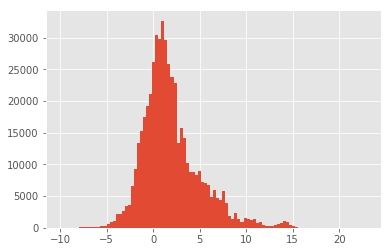

In [161]:
coint_z_scores.hist(bins=100)

In [162]:
start_date = datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc)
end_date = datetime(2018, 11, 15, 0, 0, 0, 0, pytz.utc)
total = (end_date - start_date).days

In [163]:
portfolio_value = []

with tqdm_notebook(total=total) as pbar:
    def initialize(context):
        zipline.api.set_benchmark(zipline.api.symbol("BTC-USD"))
        zipline.api.set_commission(zipline.api.commission.PerShare(cost=0, min_trade_cost=0))
        
        context.z_score_open_thresholds = [1.5, 2, 3, 4]
        context.z_score_close = 0
        context.assets_names = ["BTC-USD", "LTC-USD"]
        context.portfolio_value_before_trade = context.portfolio.portfolio_value
        
        context.assets = [zipline.api.symbol("BTC-USD"), zipline.api.symbol("LTC-USD")]
        context.z_score_open = 0
        context.is_closing_positions = False
        context.is_in_betting = False
        context.minutes_to_wait = 0
        
        context.coint_z_scores = None
        zipline.api.schedule_function(daily_update, 
                                      date_rule=zipline.api.date_rules.every_day(),
                                      time_rule=zipline.api.time_rules.market_open(hours=1))
        context.is_look_for_new_pair = True
        context.current_allocation_level = 0
        
    def daily_update(context, data):
        print(f"{zipline.api.get_datetime()}, {zipline.api.get_datetime().weekday()}")
        cur_portfolio_value = context.portfolio.portfolio_value
        print(f"Current Portfolio Value: {cur_portfolio_value}")
        pbar.update(1)
        
            
    def order_assets(context, data, is_long, z_score):
        current_datetime = zipline.api.get_datetime()
        portfolio_weights = assets_weights.loc[current_datetime].values
        
        if is_long:
            portfolio_weights *= -1
        
        new_level = 0
        for level_index, z_score_level in enumerate(context.z_score_open_thresholds):
            if abs(z_score) >= z_score_level:
                new_level = level_index + 1
            else:
                break
                
        if new_level > context.current_allocation_level:
            context.portfolio_value_before_trade = context.portfolio.portfolio_value
            print(f"New allocation level {new_level}")
            if z_score > 0:
                print("Shorting")
            else:
                print("Longing")
            portfolio_weights *= (new_level / len(context.z_score_open_thresholds))
            for asset_index, asset in enumerate(context.assets):
                print(f"Order {asset} {portfolio_weights[asset_index]}")
                zipline.api.order_target_percent(asset, portfolio_weights[asset_index])

            context.z_score_open = z_score
            context.is_in_betting = True
            context.current_allocation_level = new_level
            context.is_in_trade = True
            
        
    def close_positions(context, data):
        for order in zipline.api.get_open_orders():
            zipline.api.cancel_order(order)
            
        for asset in context.portfolio.positions.keys():
            zipline.api.order_target_percent(asset, 0)
        context.position = 0
        context.z_score_open = 0
        context.is_closing_positions = True
        context.current_allocation_level = 0
        context.is_in_trade = False
    
    def handle_data(context, data):
        positions_amount = len(context.portfolio.positions)
        open_orders_amount = len(zipline.api.get_open_orders()) 
        
        cur_portfolio_value = context.portfolio.portfolio_value
        portfolio_value.append(cur_portfolio_value)
        
        current_datetime = zipline.api.get_datetime()
        z_score = coint_z_scores.loc[current_datetime]
            
        #print("----------------------")
        positions_value = context.portfolio.positions_value
        #print(z_score, cur_portfolio_value)
        #print(zipline.api.get_open_orders())
            
        if positions_amount == 0:
            context.is_closing_positions = False                
        
        if context.is_closing_positions and positions_amount > 0 and open_orders_amount == 0:
            close_positions(context, data)                
        elif not context.is_closing_positions:
            portfolio_value_change = cur_portfolio_value / context.portfolio_value_before_trade - 1
            if z_score > context.z_score_open_thresholds[0] and context.z_score_open >= 0 and open_orders_amount == 0:
                order_assets(context, data, False, z_score)
            elif z_score < -context.z_score_open_thresholds[0] and context.z_score_open <= 0 and open_orders_amount == 0:
                order_assets(context, data, True, z_score) 
            elif (context.z_score_open > 0 and z_score <= context.z_score_close) or\
                 (context.z_score_open < 0 and z_score >= -context.z_score_close):
                print("Closing Positions")
                close_positions(context, data)

    perfomance = zipline.run_algorithm(start=start_date,
                                   end=end_date,
                                   initialize=initialize,
                                   trading_calendar=AlwaysOpenCalendar(),
                                   handle_data=handle_data,
                                   capital_base=1000,
                                   data_frequency='minute',
                                   data=backtest_panel)

2018-03-01 00:59:00+00:00, 3
Current Portfolio Value: 1000.0
2018-03-02 00:59:00+00:00, 4
Current Portfolio Value: 1000.0
New allocation level 1
Shorting
Order Equity(2 [BTC-USD]) 0.13299887804289326
Order Equity(1 [LTC-USD]) -0.11700112195710677
2018-03-03 00:59:00+00:00, 5
Current Portfolio Value: 998.2468780500001
2018-03-04 00:59:00+00:00, 6
Current Portfolio Value: 1002.90856805
2018-03-05 00:59:00+00:00, 0
Current Portfolio Value: 1003.41466805
New allocation level 2
Shorting
Order Equity(2 [BTC-USD]) 0.2650357086997819
Order Equity(1 [LTC-USD]) -0.23496429130021818
New allocation level 3
Shorting
Order Equity(2 [BTC-USD]) 0.3968894346781277
Order Equity(1 [LTC-USD]) -0.35311056532187235
2018-03-06 00:59:00+00:00, 1
Current Portfolio Value: 1000.9315525100001
New allocation level 4
Shorting
Order Equity(2 [BTC-USD]) 0.5288834633041338
Order Equity(1 [LTC-USD]) -0.47111653669586606
2018-03-07 00:59:00+00:00, 2
Current Portfolio Value: 998.685229485
2018-03-08 00:59:00+00:00, 3
Cur

2018-05-04 00:59:00+00:00, 4
Current Portfolio Value: 946.3180490149998
New allocation level 1
Longing
Order Equity(2 [BTC-USD]) -0.1275796620660931
Order Equity(1 [LTC-USD]) 0.12242033793390687
New allocation level 2
Longing
Order Equity(2 [BTC-USD]) -0.2539533238765453
Order Equity(1 [LTC-USD]) 0.24604667612345466
New allocation level 3
Longing
Order Equity(2 [BTC-USD]) -0.37865426663024654
Order Equity(1 [LTC-USD]) 0.37134573336975346
2018-05-05 00:59:00+00:00, 5
Current Portfolio Value: 950.988519415
New allocation level 4
Longing
Order Equity(2 [BTC-USD]) -0.4929206213406322
Order Equity(1 [LTC-USD]) 0.5070793786593679
2018-05-06 00:59:00+00:00, 6
Current Portfolio Value: 965.200356585
2018-05-07 00:59:00+00:00, 0
Current Portfolio Value: 954.7333565849999
2018-05-08 00:59:00+00:00, 1
Current Portfolio Value: 951.818196585
2018-05-09 00:59:00+00:00, 2
Current Portfolio Value: 941.4768365849999
Closing Positions
2018-05-10 00:59:00+00:00, 3
Current Portfolio Value: 936.522054345
20

2018-07-02 00:59:00+00:00, 0
Current Portfolio Value: 945.8850389500003
2018-07-03 00:59:00+00:00, 1
Current Portfolio Value: 944.6174389500003
2018-07-04 00:59:00+00:00, 2
Current Portfolio Value: 938.2983389500004
2018-07-05 00:59:00+00:00, 3
Current Portfolio Value: 942.3506389500003
2018-07-06 00:59:00+00:00, 4
Current Portfolio Value: 947.0522389500003
2018-07-07 00:59:00+00:00, 5
Current Portfolio Value: 952.0493389500004
2018-07-08 00:59:00+00:00, 6
Current Portfolio Value: 958.0760389500003
2018-07-09 00:59:00+00:00, 0
Current Portfolio Value: 962.6879389500003
2018-07-10 00:59:00+00:00, 1
Current Portfolio Value: 968.5700389500004
2018-07-11 00:59:00+00:00, 2
Current Portfolio Value: 959.6499389500003
2018-07-12 00:59:00+00:00, 3
Current Portfolio Value: 957.9028389500004
2018-07-13 00:59:00+00:00, 4
Current Portfolio Value: 951.9457389500003
2018-07-14 00:59:00+00:00, 5
Current Portfolio Value: 952.5000389500004
2018-07-15 00:59:00+00:00, 6
Current Portfolio Value: 955.415638

2018-09-28 00:59:00+00:00, 4
Current Portfolio Value: 1004.9894940000004
2018-09-29 00:59:00+00:00, 5
Current Portfolio Value: 991.3585540000005
2018-09-30 00:59:00+00:00, 6
Current Portfolio Value: 995.8539740000003
2018-10-01 00:59:00+00:00, 0
Current Portfolio Value: 992.9831340000004
2018-10-02 00:59:00+00:00, 1
Current Portfolio Value: 987.8298740000005
2018-10-03 00:59:00+00:00, 2
Current Portfolio Value: 984.5217140000004
Closing Positions
2018-10-04 00:59:00+00:00, 3
Current Portfolio Value: 977.9762239200004
2018-10-05 00:59:00+00:00, 4
Current Portfolio Value: 977.9762239200004
2018-10-06 00:59:00+00:00, 5
Current Portfolio Value: 977.9762239200004
2018-10-07 00:59:00+00:00, 6
Current Portfolio Value: 977.9762239200004
2018-10-08 00:59:00+00:00, 0
Current Portfolio Value: 977.9762239200004
2018-10-09 00:59:00+00:00, 1
Current Portfolio Value: 977.9762239200004
New allocation level 1
Shorting
Order Equity(2 [BTC-USD]) 0.13328965446348373
Order Equity(1 [LTC-USD]) -0.1167103455

Algorithm Period Return: 0.004227161845041794
Aglorithm Period Volatility: 0.1181405318647381
Benchmark Period Return: -0.3747938294363049
Benchmark Period Volatility: 0.5520600829219817


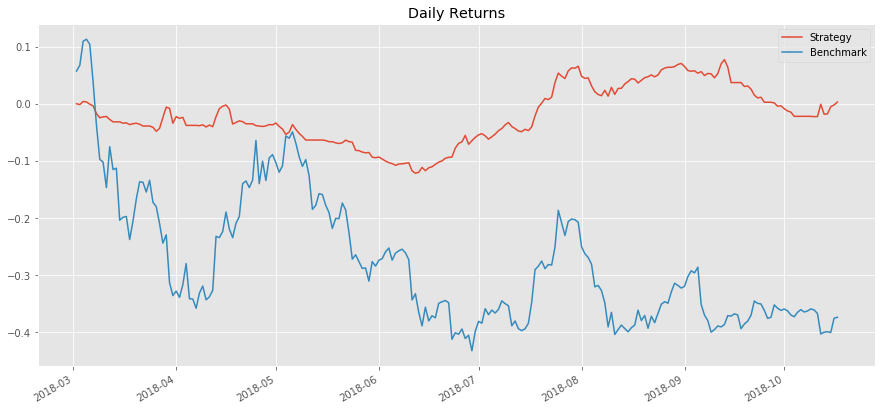

In [164]:
plt.figure(figsize=(15, 7))
plt.title("Daily Returns")
perfomance.algorithm_period_return[:-30].plot(label="Strategy")
perfomance.benchmark_period_return[:-30].plot(label="Benchmark")

print("Algorithm Period Return:", perfomance.algorithm_period_return[-30])
print("Aglorithm Period Volatility:", perfomance.algo_volatility[-30])
print("Benchmark Period Return:", perfomance.benchmark_period_return[-30])
print("Benchmark Period Volatility:", perfomance.benchmark_volatility[-30])
plt.legend();

In [165]:
print("Alpha:", perfomance.alpha[-30])
print("Beta:", perfomance.beta[-30])
print("Max Drawdown:", perfomance.max_drawdown[-30])
print("Sortino:", perfomance.sortino[-30])

Alpha: 0.02773007936601788
Beta: 0.04503351090443218
Max Drawdown: -0.12513741821865834
Sortino: 0.14011840177227552


Sharpe Ratio: 0.09777872796813702


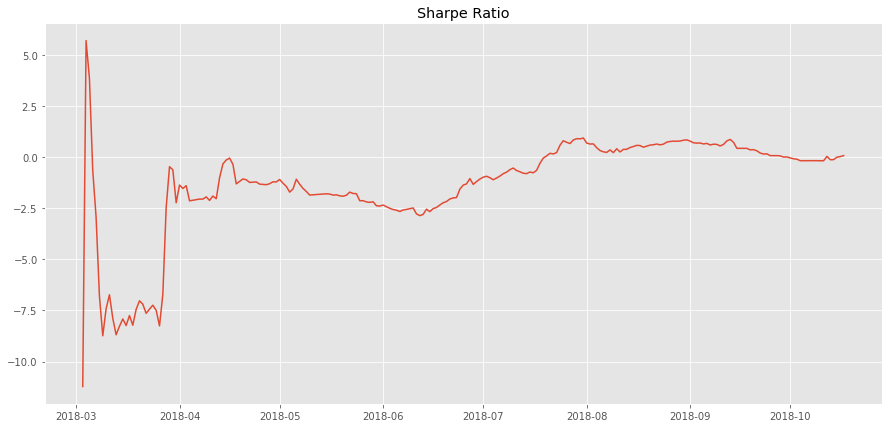

In [166]:
plt.figure(figsize=(15, 7))
plt.title("Sharpe Ratio")
plt.plot(perfomance.sharpe[:-30])
print("Sharpe Ratio:", perfomance.sharpe[-30])